In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib


X_test = joblib.load('/content/drive/My Drive/Master_Thesis/X_test.pkl')
y_test = joblib.load('/content/drive/My Drive/Master_Thesis/y_test.pkl')
X_combined = joblib.load('/content/drive/My Drive/Master_Thesis/X_combined.pkl')
y_combined = joblib.load('/content/drive/My Drive/Master_Thesis/y_combined.pkl')
best_xgb_classifier = joblib.load('/content/drive/My Drive/Master_Thesis/best_xgb_classifier_combined(vector_size=300,window= 4).pkl')
X_test_combined= joblib.load('/content/drive/My Drive/Master_Thesis/X_test_combined.pkl')

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

# Define lemmatization function
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    # Convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    # Return lemmatized tokens as a list
    return lemmas

# Custom preprocessing function
def preprocessing(text):
    # Convert text to lowercase
    lower_text = text.lower()

    # Remove punctuation
    punctuation_free = "".join([char for char in lower_text if char not in string.punctuation])

    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', punctuation_free)

    # Remove digits
    remove_digits = re.sub(r'\d', '', remove_urls)

    # Tokenize text
    tokenized_text = word_tokenize(remove_digits)

    # Remove stop words
    filtered_tokens = [token for token in tokenized_text if token not in stop_words]

    # Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    return lemmatized_tokens  # Return tokenized and lemmatized tokens
# Check the first few rows of X_combined
print("First few rows of X_combined:")
print(X_combined.head())

# Ensure X_combined is a Series
if not isinstance(X_combined, pd.Series):
    raise TypeError("X_combined is not a Series.")

# Define TF-IDF Vectorizer pipeline
tfidf_data_augmented = Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer=lambda text: preprocessing(text),  # Custom preprocessing function
        stop_words='english',        # Remove English stopwords
        ngram_range=(1, 1)           # Consider only unigrams
    ))
])

# Fit and transform the combined data
X_combined_tfidf = tfidf_data_augmented.fit_transform(X_combined)
X_test_tfidf = tfidf_data_augmented.transform(X_test)

# Train Word2Vec model with tokenized sentences
tokenized_combined = [preprocessing(post) for post in X_combined]
tokenized_test = [preprocessing(post) for post in X_test]
word2vec_model = Word2Vec(sentences=tokenized_combined, vector_size=300,window= 4)

# Function to obtain Word2Vec embedding for a sentce
def get_word2vec_embedding(model, tokens, size=300):  # Changed size to 200 to match vector_size
    vec = np.zeros(size)
    count = 0
    for token in tokens:
        if token in model.wv:
            vec += model.wv[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

# Obtain Word2Vec embeddings for each post
X_train_word2vec = np.array([get_word2vec_embedding(word2vec_model, post) for post in tokenized_combined])
X_test_word2vec = np.array([get_word2vec_embedding(word2vec_model, post) for post in tokenized_test])

# VADER Sentiment Analysis
sia = SentimentIntensityAnalyzer()
X_train_vader = np.array([list(sia.polarity_scores(' '.join(doc)).values()) for doc in tokenized_combined])
X_test_vader = np.array([list(sia.polarity_scores(' '.join(doc)).values()) for doc in tokenized_test])

# Combine features
X_train_combined = np.concatenate((X_combined_tfidf.toarray(), X_train_word2vec, X_train_vader), axis=1)
X_test_combined = np.concatenate((X_test_tfidf.toarray(), X_test_word2vec, X_test_vader), axis=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


First few rows of X_combined:
150      i am sorry, but the text "jessicafilan it is" ...
6887     i had a rough day today. it felt like everythi...
13077    i just can't shake this feeling of dread that ...
9513     i feel overwhelmed and torn between two confli...
9666     i find myself in the same boat every night, dr...
dtype: object


In [ ]:

print("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])
print("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])

# Compute sample weights for handling class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=y_combined)

# Define the best parameters for XGBClassifier
best_xgb_params = {
    'n_estimators': 120,
    'min_child_weight': 1,
    'max_depth': 5,
    'learning_rate': 0.23,
    'lambda': 0.04,
    'gamma': 0.7,
    'alpha': 0.1
}

# Create XGBClassifier with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)

# Fit the model with the transformed training data
best_xgb_classifier.fit(X_train_combined, y_combined, sample_weight=sample_weights)


'\nprint("Number of features in X_combined_tfidf:", X_combined_tfidf.shape[1])\nprint("Number of features in X_test_tfidf:", X_test_tfidf.shape[1])\n\n# Compute sample weights for handling class imbalance\nsample_weights = compute_sample_weight(class_weight=\'balanced\', y=y_combined)\n\n# Define the best parameters for XGBClassifier\nbest_xgb_params = {\n    \'n_estimators\': 120,\n    \'min_child_weight\': 1,\n    \'max_depth\': 5,\n    \'learning_rate\': 0.23,\n    \'lambda\': 0.04,\n    \'gamma\': 0.7,\n    \'alpha\': 0.1\n}\n\n# Create XGBClassifier with the best parameters\nbest_xgb_classifier = xgb.XGBClassifier(**best_xgb_params)\n\n# Fit the model with the transformed training data\nbest_xgb_classifier.fit(X_train_combined, y_combined, sample_weight=sample_weights)\n\n'

In [ ]:
y_pred = best_xgb_classifier.predict(X_test_combined)

classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       780
           1       0.73      0.75      0.74       252
           2       0.80      0.76      0.78       279
           3       0.73      0.71      0.72       236

    accuracy                           0.85      1547
   macro avg       0.80      0.80      0.80      1547
weighted avg       0.85      0.85      0.85      1547



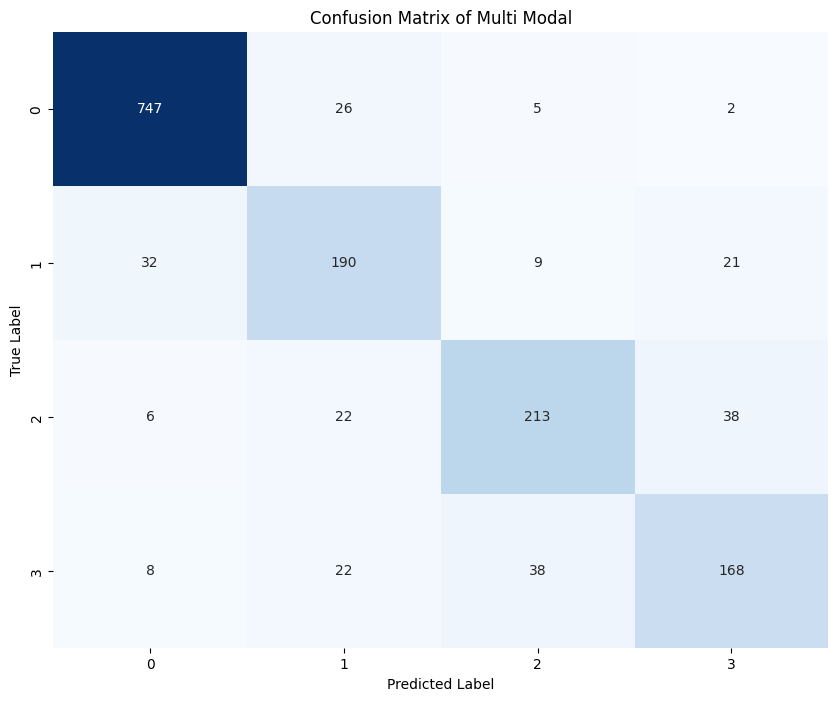

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Multi Modal')
#plt.savefig('/content/drive/My Drive/Master_Thesis/confusion matrix XGBoost.png')
plt.show()